# <p align="center">Generación de paleta de colores a partir de imágenes con técnicas de Machine Learning no supervisado</p>


# <p align="center">Microproyecto 1</p>


### <p align="center">Camilo Rodriguez</p>
### <p align="center">Monica Alvarez</p>



Se importan las librerías necesarias para el desarrollo del proyecto.

Las principales librerías que se utilizan:
- OpenCV: Utilizado principalmente para la manipulación y procesamiento de imágenes.
- Matplotlib: Utilizado para la visualización de datos, gráficos y resultados del modelo.
- Scikit-learn: Proporciona herramientas clave para la implementación de algoritmos de machine learning


In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from scipy.cluster.hierarchy import linkage
from kmedoids import KMedoids  

Las imágenes fueron descargadas de la base de datos proporcionada por el profesor, junto con un archivo CSV que contiene la información de las imágenes,como URLs, artista y estilo de la obra.

A continuación, se carga el archivo CSV y visualizamos la información que contiene.

In [3]:
clases = pd.read_csv('classes.csv')
clases.head(5)

filename         artist  \
0  Abstract_Expressionism/aaron-siskind_acolman-1...  aaron siskind   
1  Abstract_Expressionism/aaron-siskind_chicago-6...  aaron siskind   
2  Abstract_Expressionism/aaron-siskind_glouceste...  aaron siskind   
3  Abstract_Expressionism/aaron-siskind_jerome-ar...  aaron siskind   
4  Abstract_Expressionism/aaron-siskind_kentucky-...  aaron siskind   

                        genre          description             phash  width  \
0  ['Abstract Expressionism']       acolman-1-1955  bebbeb018a7d80a8   1922   
1  ['Abstract Expressionism']       chicago-6-1961  d7d0781be51fc00e   1382   
2  ['Abstract Expressionism']  gloucester-16a-1944  9f846e5a6c639325   1382   
3  ['Abstract Expressionism']  jerome-arizona-1949  a5d691f85ac5e4d0   1382   
4  ['Abstract Expressionism']      kentucky-4-1951  880df359e6b11db1   1382   

   height  genre_count subset  
0    1382            1  train  
1    1746            1  train  
2    1857            1  train  
3    1849            1  train  
4    1625            1  train

Al momento de descomprimir el archivo de imágenes, se observa que las imágenes con títulos que contienen caracteres especiales no se descomprimen correctamente, quedando como archivos corruptos. Por lo tanto, se procede a filtrar aquellas imágenes cuyos títulos están correctos.
Este filtrado se realiza utilizando expresiones regulares.

In [4]:
clases_filtred = clases[clases['filename'].str.contains(r'^[a-zA-Z0-9_/\-.]+$', regex=True)] #filtro titulo de las imagenes
clases_filtred['path'] = 'archive/' + clases_filtred['filename'] #agrego la ruta de las imagenes

/var/folders/18/88x5gxxj0wq949rkr1_qj3_45113mn/T/ipykernel_74709/665221271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clases_filtred['path'] = 'archive/' + clases_filtred['filename'] #agrego la ruta de las imagenes


Con los títulos de las imagenes filtradas, se selecciona un subconjunto de las imagenes para trabajar. En este caso, se toman dos imágenes para hacer pruebas de los modelos.

In [5]:
images_random = clases_filtred['path'].sample(n=2, random_state=35)
images_random

64422    archive/Abstract_Expressionism/sam-francis_unt...
66109       archive/Baroque/rembrandt_holy-family-1640.jpg
Name: path, dtype: object

Con la direccion de la imagen, se procede a cargarla y redimensionarla para poder trabajar con ella.

El valor de la redimensión es de 224x224 píxeles.

Las imágenes redimensionadas se almacenan en una lista llamada `images`.

In [6]:
images = []
for ima in  images_random:
    image = cv2.imread(ima)
    image_resized = cv2.resize(image, (224,224), interpolation=cv2.INTER_AREA)
    images.append(image_resized)

La siguiente función `optimal_cluster_number` usa la técnica del "Elbow Method", para buscar el número óptimo de clusters en la imagen que se le pase como parámetro.

In [7]:
def optimal_cluster_number(data):
    silhouette_scores = []
    inertias = []
    min_k = 3 # Mínimo número de clusters
    max_clusters=9 # Número máximo de clusters para liomitar la busqueda
    k_range = range(min_k, max_clusters + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42) # Inicialización del modelo
        kmeans.fit(data) # fitteo del modelo
        silhouette_scores.append(silhouette_score(data, kmeans.labels_)) # Cálculo del silhouette score
        inertias.append(kmeans.inertia_) # Cálculo de la inercia
    
    # Normalizar inercias para la visualización
    inertias = np.array(inertias)
    inertias = (inertias - inertias.min()) / (inertias.max() - inertias.min())
    
    # Encontrar el número óptimo de clusters
    k_silhouette = silhouette_scores.index(max(silhouette_scores)) + min_k
    k_elbow = np.argmin(np.diff(inertias)) + min_k
    
    # Visualizar los métodos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Silhouette score
    ax1.plot(k_range, silhouette_scores)
    ax1.plot(k_silhouette, silhouette_scores[k_silhouette-min_k], 'ro')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Method')
    
    # Elbow method
    ax2.plot(k_range, inertias)
    ax2.plot(k_elbow, inertias[k_elbow-min_k], 'ro')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Inertia (normalized)')
    ax2.set_title('Elbow Method')
    
    plt.tight_layout()
    plt.show()
    
    # Retornar el promedio de los dos métodos
    return int((k_silhouette + k_elbow) / 2)
    

La función `show_image_and_palette` se encarga de entrenar el modelo KMeans con la imagen que se le pase como parámetro. Posteriormente, muestra tanto la imagen original como la paleta de colores generada por el modelo.

Al inicio de la función, se realiza un pequeño preprocesamiento de la imagen, de la siguiente manera:
- Se cambia el canal de color BGR a RGB.
- Se hace un reshape de la imagen para que quede en un formato de 2D
- Se normaliza la imagen. 

Finalmente, se entrena el modelo y se hace una transformación inversa de los centroides para poder visualizar la imagen original.

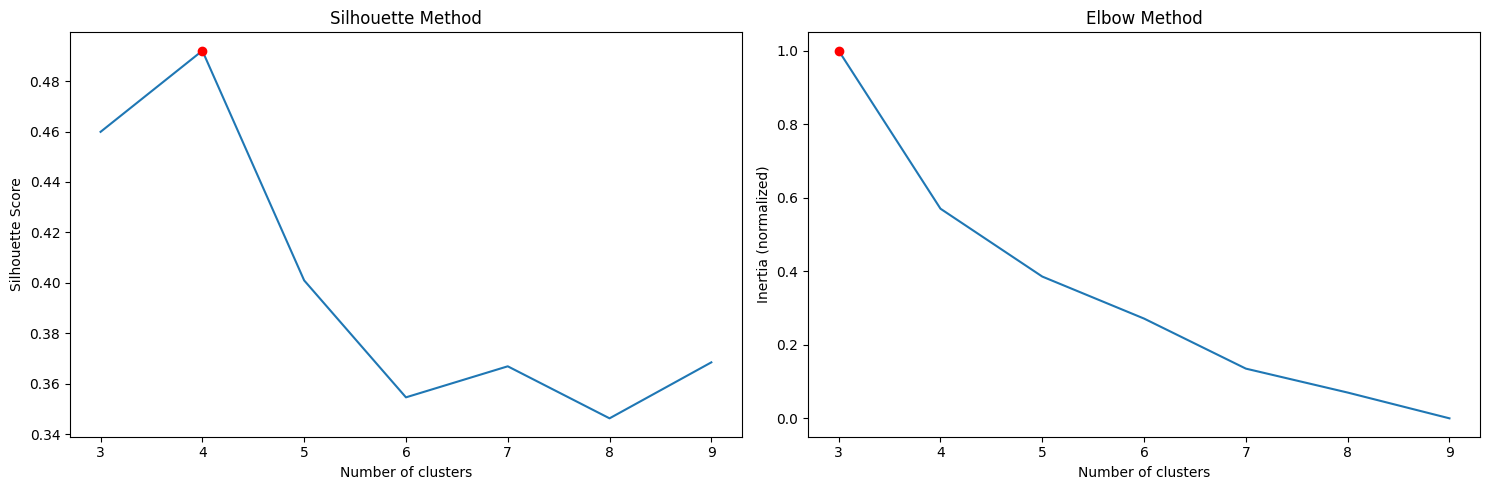

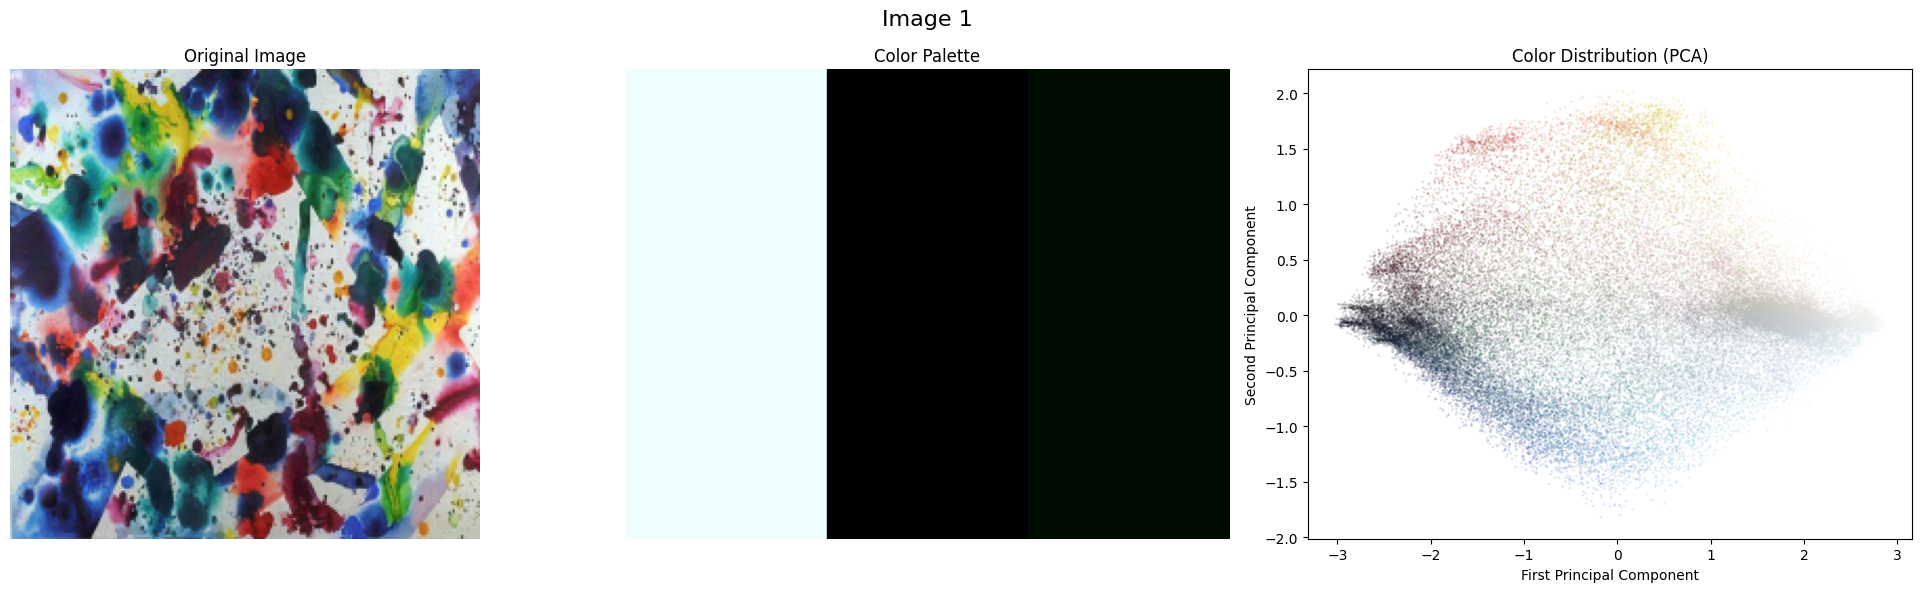

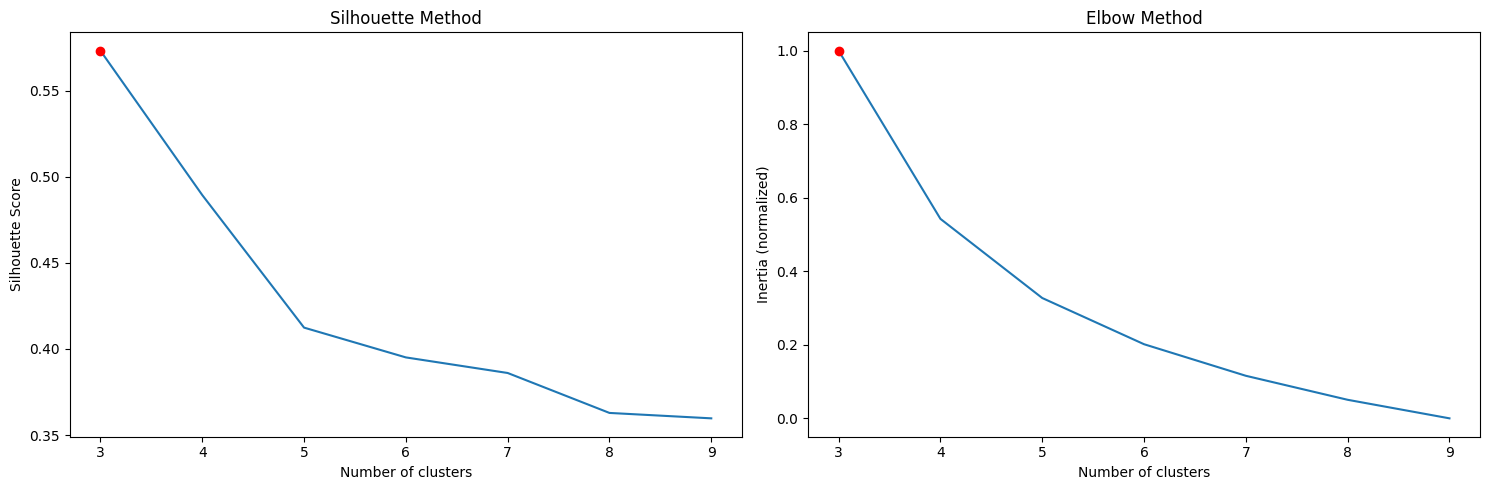

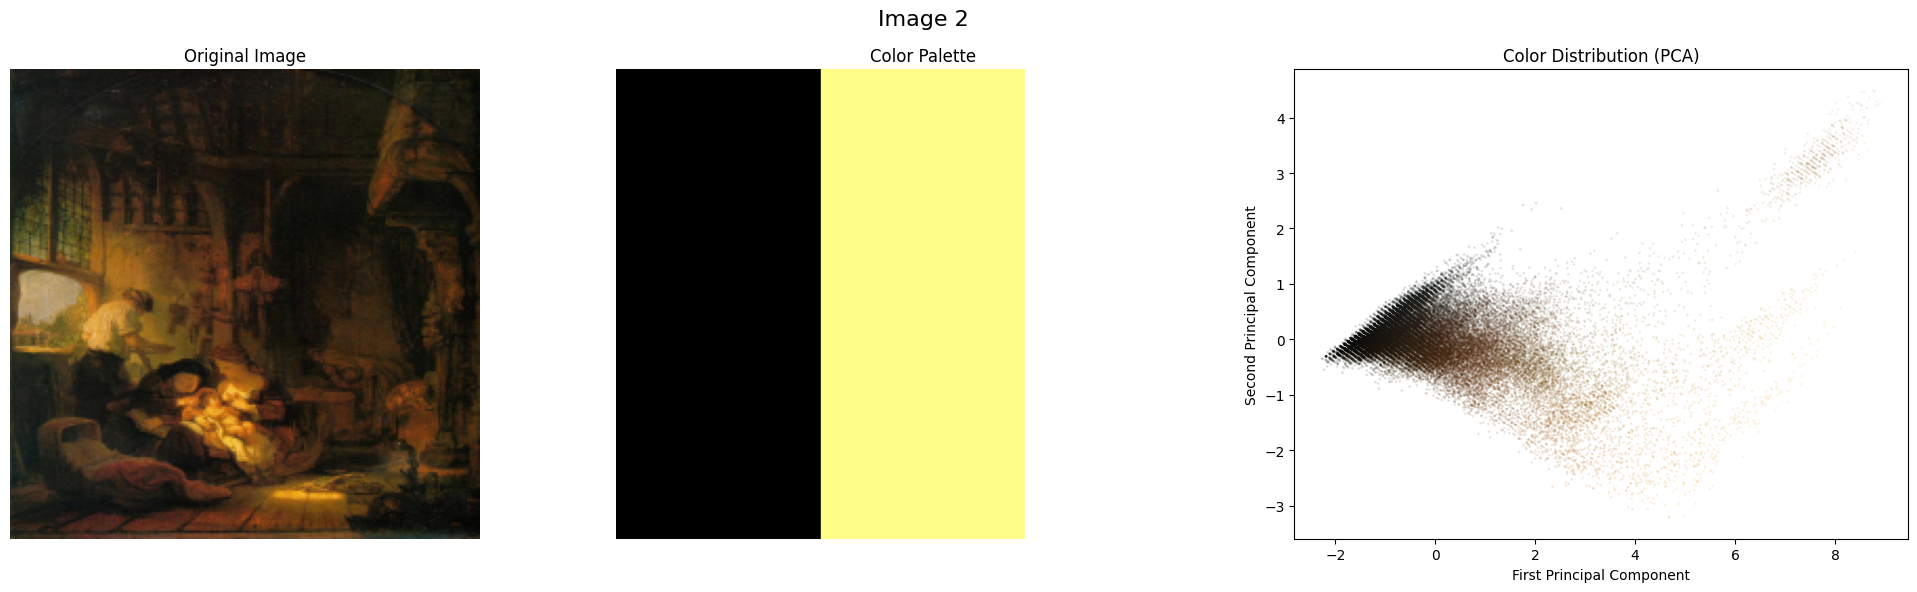

In [8]:
def show_image_and_palette(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convertir la imagen a RGB
    
    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    n_colors = optimal_cluster_number(normalized_imag)
    print(f"Optimal number of clusters for {title}: {n_colors}")

    kmeans = KMeans(n_clusters=n_colors, random_state=42)


    kmeans.fit(normalized_imag)

    colors = kmeans.cluster_centers_
    colors = np.clip(colors * 255, 0, 255).astype(int)


    pca = PCA(n_components=2)
    pixels_2d = pca.fit_transform(normalized_imag)
    
    #unque_colors = np.unique(colors, axis=0)
    #unque_colors = colors
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)
    ax1.imshow(image_rgb)
    ax1.axis('off')
    ax1.set_title('Original Image')


    for i, color in enumerate(colors):
        ax2.axvspan(i, i+1, color=color/255)
    ax2.set_xlim(0, len(colors))
    ax2.axis('off')
    ax2.set_title('Color Palette')

    ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
    ax3.set_title('Color Distribution (PCA)')
    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

    return colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)


En la siguiente función `show_image_and_palette_kmedoids`realiza el mismo proceso que la función anterior,  en este caso utilizando el modelo KMedoids. Cabe resaltar que el modelo KMedoids es un modelo más robusto que el KMeans, ya que, en lugar de calcular los centroides de los clusters, se calculan los puntos más cercanos a estos, lo que se traduce en un mayor tiempo de ejecución del modelo sin permitir una optimización significativa de los clusters. 

Se dejó corriendo el modelo KMedoids con 8 clusters por aproximadamente 8 horas, para compararlo con el modelo KMeans pero no logró converger, por lo que se tomó la decisión de no incluirlo en el proyecto.

In [12]:
def show_image_and_palette_kmedoids(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{title} - Original Image")
    
    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    kmedoids = KMedoids(n_clusters=8, random_state=42, metric='euclidean')
    kmedoids.fit(normalized_imag)

    colors = kmedoids.cluster_centers_
    colors = np.clip(colors * 255, 0, 255).astype(int)

    plt.subplot(1, 2, 2)
    for i, color in enumerate(colors):
        plt.axvspan(i, i+1, color=color/255)
    plt.axis('off')
    plt.title(f"{title} - Color Palette")
    
    plt.tight_layout()
    plt.show()

    return colors


palettes = []
titles = []

for i, image in enumerate(images[:2]):
    title = f"Image {i+1}"
    palette = show_image_and_palette_kmedoids(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)

La siguiente función `optimal_cluster_number_linkage` utiliza la técnica de distancias de Ward para determinar el número óptimo de *clusters* en la imagen que se le pase como parámetro.

In [9]:
def optimal_cluster_number_linkage(data):
    max_clusters=7 # Número máximo de clusters para limitar la busqueda
    # Calcular la matriz de enlace
    linkage_matrix = linkage(data, method='ward') # Método de enlace
    
    # Calcular las distancias de enlace para diferentes números de clusters
    last = linkage_matrix[-max_clusters:, 2] # Últimos max_clusters elementos
    last_rev = last[::-1] # Revertir el orden
    idxs = np.arange(1, len(last) + 1) # Índices para el número de clusters
    
    # Calcular la aceleración de la curva
    acceleration = np.diff(last_rev, 2) # Segunda derivada de la curva
    acceleration_rev = acceleration[::-1] # Revertir el orden
    
    k = acceleration_rev.argmax() + 2  # El número óptimo de clusters
    
    # Visualizar el método del codo
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(idxs, last_rev)
    plt.plot(idxs[k-1], last_rev[k-1], 'ro')
    plt.xlabel('Number of clusters')
    plt.ylabel('Linkage distance')
    plt.title('Elbow Method for Optimal k')
    
    # Visualizar la aceleración
    plt.subplot(122)
    plt.plot(idxs[:-2], acceleration_rev)
    plt.plot(idxs[k-2], acceleration_rev[k-2], 'ro')
    plt.xlabel('Number of clusters')
    plt.ylabel('Acceleration of linkage distance')
    plt.title('Acceleration Method for Optimal k')
    
    plt.tight_layout()
    plt.show()
    
    return k

La siguiente función `show_image_and_palette_AgglomerativeClustering` se encarga de entrenar el modelo `AgglomerativeClustering` con la imagen que se le pase como parámetro y mostrar tanto la imagen original como la paleta de colores generada por el modelo. 

Al igual que en la función de `show_image_and_palette` que implementa el modelo de KMeans, se realiza un pequeño preprocesamiento de la imagen:
- Se cambia el canal de color de BGR a RGB.
- Se reorganiza la imagen en un formato 2D mediante un reshape.
- Se normaliza la imagen.

Posteriormente, se entrena el modelo y se hace una transformación inversa de los centróides para visualizar la imagen original.
También, se aplica PCA a la imagen para reducir su dimensionalidad y poder visualizarla en 2D, lo que permite comparar los resultados de los diferentes modelos.

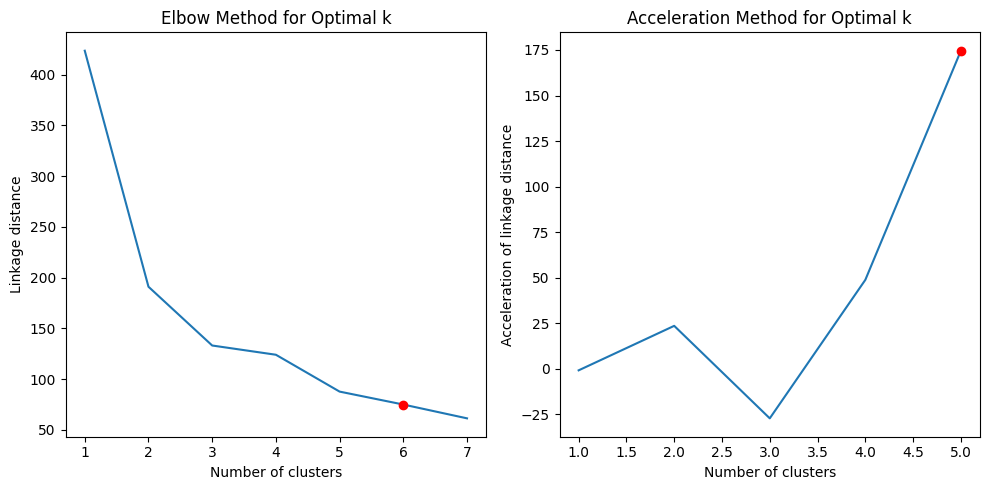

Optimal number of clusters for Image 1: 6


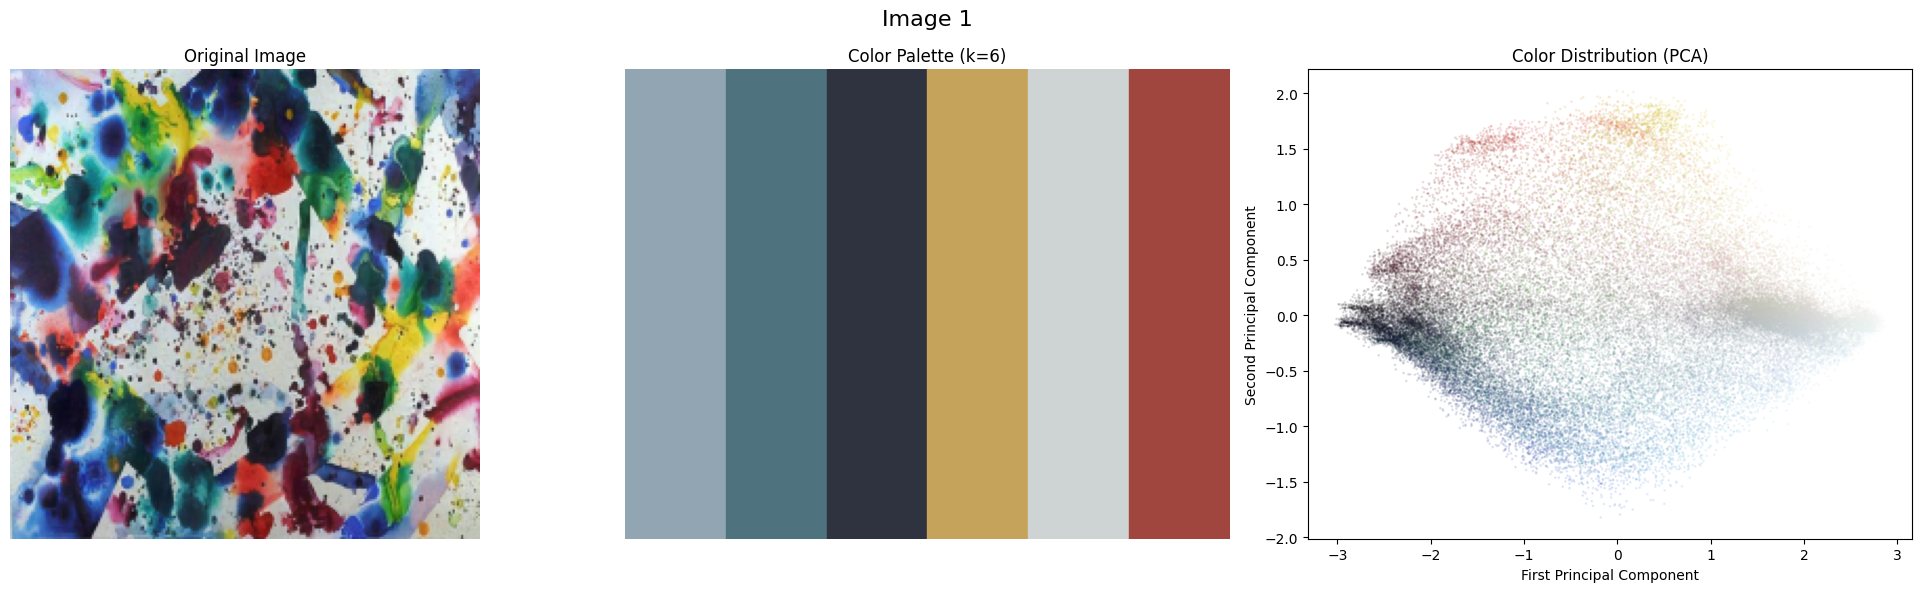

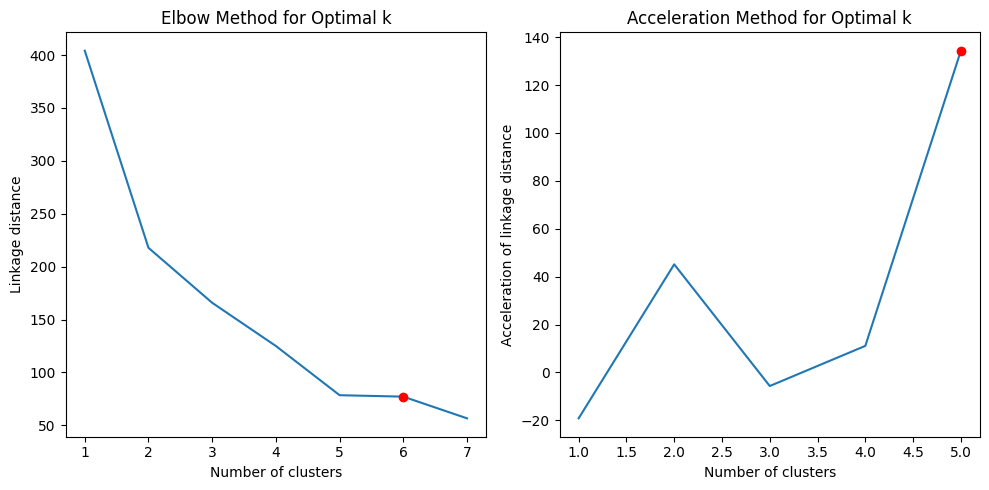

Optimal number of clusters for Image 2: 6


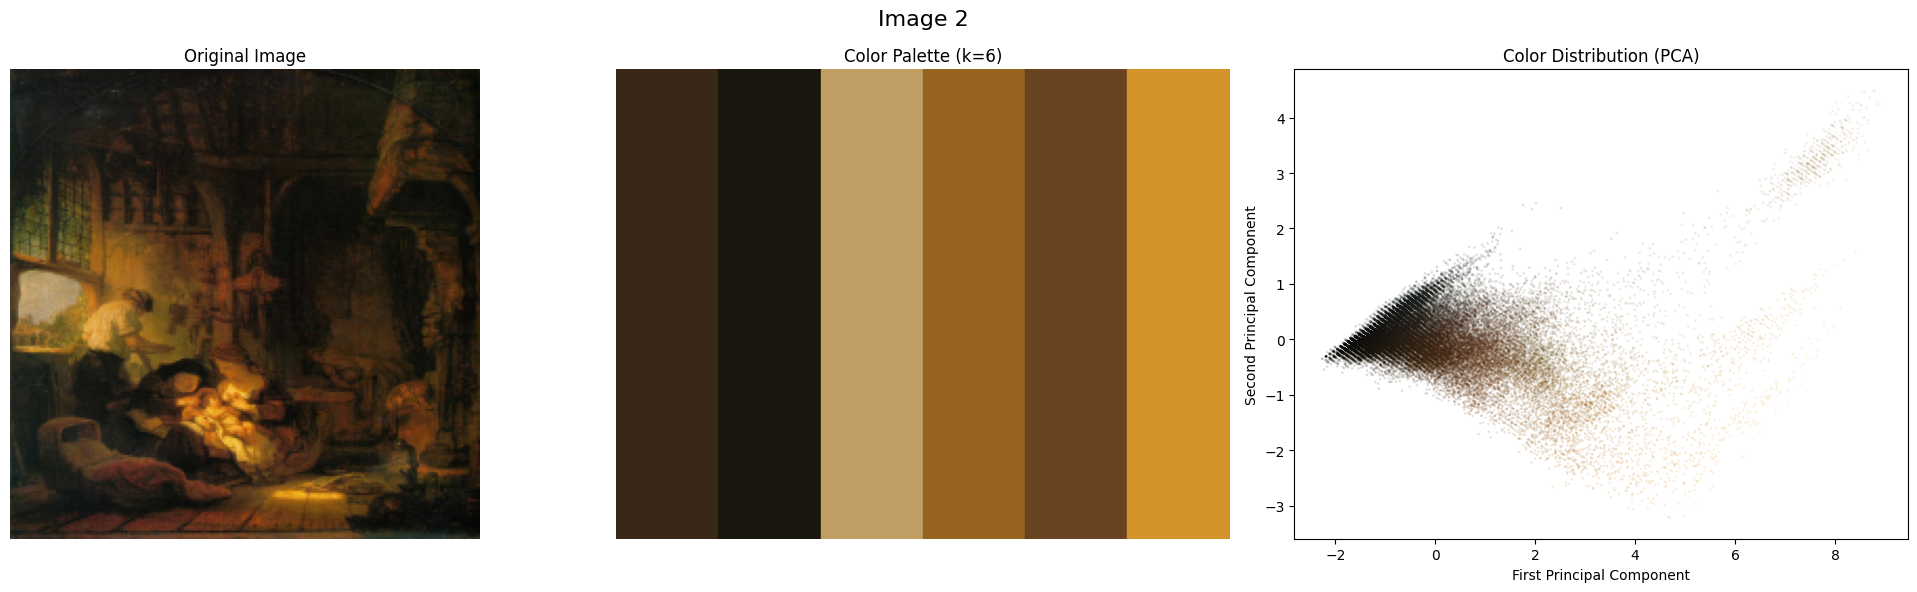

In [12]:
def show_image_and_palette_AgglomerativeClustering(image, title):
      
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    ima = image_rgb.reshape(-1, 3)
    scaler = StandardScaler()
    normalized_imag = scaler.fit_transform(ima)

    n_colors = optimal_cluster_number_linkage(normalized_imag)
    print(f"Optimal number of clusters for {title}: {n_colors}")

    agglo = AgglomerativeClustering(n_clusters=n_colors)
    agglo.fit(normalized_imag)

    colors = []
    for i in range(n_colors):
        cluster_pixels = ima[agglo.labels_ == i]
        avg_color = np.mean(cluster_pixels, axis=0)
        colors.append(avg_color)

    
    colors = np.array(colors)
    colors = np.clip(colors, 0, 255).astype(int)

    # Aplicar PCA
    pca = PCA(n_components=2)
    pixels_2d = pca.fit_transform(normalized_imag)

    # Crear la visualización
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(title, fontsize=16)

    # Mostrar la imagen original
    ax1.imshow(image_rgb)
    ax1.axis('off')
    ax1.set_title('Original Image')

    # Mostrar la paleta de colores
    for i, color in enumerate(colors):
        ax2.axvspan(i, i+1, color=color/255)
    ax2.set_xlim(0, len(colors))
    ax2.axis('off')
    ax2.set_title(f'Color Palette (k={n_colors})')

    # Visualizar la distribución de colores con PCA
    ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
    ax3.set_title('Color Distribution (PCA)')
    ax3.set_xlabel('First Principal Component')
    ax3.set_ylabel('Second Principal Component')

    plt.tight_layout()
    plt.show()

    return colors



palettes = []
titles = []

for i, image in enumerate(images):
    title = f"Image {i+1}"
    palette = show_image_and_palette_AgglomerativeClustering(image, title)
    if palette is not None:
        palettes.append(palette)
        titles.append(title)

## Creación del pipeline

A continuación, se construye un pipeline con el objetivo de automatizar el flujo de trabajo de procesamiento de imágenes.

El pipeline está compuesto por las siguientes etapas: 
- Lectura de imágenes desde rutas especificadas.
- Preprocesamiento de las imágenes, incluyendo cambios en el formato y normalización.
- Evaluación de modelos, como KMeans y AgglomerativeClustering, para agrupar los píxeles y generar paletas de colores.

Para la etapa del pipeline se hereda de la clase `BaseEstimator`  de Scikit-learn, lo que permite implementar los métodos `fit` y `transform` necesarios para el procesamiento de las imágenes.

La clase `ReadImages` se utiliza para leer imágenes desde rutas especificadas. Se usa `cv2.imread` para cargar la imagen desde la ruta dada y devolverla como una matriz de píxeles.

In [13]:
class ReadImages(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
       
    
    def transform(self, X):
        return cv2.imread(X)


La clase `ImagePreprocessor` se encarga de realizar el preprocesamiento de las imágenes de la siguiente manera;
- Redimensiona la imagen a 224x224 píxeles utilizando interpolación `cv2.INTER_AREA`.
- Cambia el espacio de color de BGR a RGB.
- Reorganiza la imagen en un formato 2D (filas de píxeles con 3 valores de color).
- Normaliza los valores de los píxeles utilizando `StandardScaler` para escalar los datos.

Finalmente, se obtiene una lista que contiene, la imagen normalizada, la imagen redimensionada en RGB y la imagen en formato 2D sin normalizar.


In [14]:
class ImagePreprocessor(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # El preprocesamiento en sí se hace en el transform
        return self

    def transform(self, X, y=None):
        image_resized = cv2.resize(X, (224,224), interpolation=cv2.INTER_AREA)
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        ima = image_rgb.reshape(-1, 3)
        scaler = StandardScaler()
        normalized_imag = scaler.fit_transform(ima)
        return [normalized_imag, image_rgb, ima]

La clase `ModelEvaluation` tiene como objetivo entrenar y evaluar modelos de clustering, para efectos de este proyecto, KMeans o AgglomerativeClustering, para generar las paletas de colores.

Implementa los siguientes métodos:

- `__init__`: Inicializa la clase, permitiendo seleccionar el modelo de clustering (`aglo` o `kmeans`). Por defecto, se usará el modelo Aglomerativo.
- `optimal_cluster_number_aglo`: Utiliza la técnica de distancias de Ward para determinar el número óptimo de clusters.
- `optimal_cluster_number_km`: Implementa el cálculo del número óptimo de clusters utilizando el modelo KMeans, combinando el "Silhouette Score" y el "Elbow Method".
- `fit`: Entrena el modelo seleccionado (AgglomerativeClustering o KMeans) con la imagen preprocesada para identificar los clusters de colores. Luego, calcula los colores promedio o los centróides de los clusters y los almacena en `self.colors`.
- `transform`: Aplica PCA para reducir la dimensionalidad de la imagen a 2D, permitiendo la visualización de la distribución de colores y muestra la imagen original, la paleta de colores generada por el modelo y la distribución de colores en el espacio reducido por PCA.
- `plot_ag` y `plot_km`: Generan visualizaciones para los métodos de AgglomerativeClustering y KMeans, mostrando las métricas clave para seleccionar el número óptimo de clusters (distancias de enlace, aceleración, el "Silhouette Score" y el "Elbow Method").


In [16]:
class ModelEvaluation(BaseEstimator):
    def __init__(self, model = 'aglo'):
        self.model = model
        pass

    def optimal_cluster_numbe_aglo(self, data, max_clusters=7):

        self.plot_list = []

        linkage_matrix = linkage(data, method='ward')
    
        # Calcular las distancias de enlace para diferentes números de clusters
        last = linkage_matrix[-max_clusters:, 2]
        last_rev = last[::-1]
        idxs = np.arange(1, len(last) + 1)
        
        # Calcular la aceleración de la curva
        acceleration = np.diff(last_rev, 2)
        acceleration_rev = acceleration[::-1]
        
        k = acceleration_rev.argmax() + 2  # El número óptimo de clusters


        self.plot_list.append(idxs)
        self.plot_list.append(last_rev)
        self.plot_list.append(acceleration_rev)
        self.plot_list.append(k)

        return k
    
    

    def optimal_cluster_number_km(self, data, max_clusters=7):


        self.plot_list = []
    
        silhouette_scores = []
        inertias = []
        min_k = 3
        k_range = range(min_k, max_clusters + 1)
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(data)
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
            inertias.append(kmeans.inertia_)
        
        # Normalizar inercias para la visualización
        inertias = np.array(inertias)
        inertias = (inertias - inertias.min()) / (inertias.max() - inertias.min())
        
        # Encontrar el número óptimo de clusters
        k_silhouette = silhouette_scores.index(max(silhouette_scores)) + min_k
        k_elbow = np.argmin(np.diff(inertias)) + min_k

        self.plot_list.append(k_range)
        self.plot_list.append(silhouette_scores)
        self.plot_list.append(k_silhouette)
        self.plot_list.append(min_k)
        self.plot_list.append(inertias)
        self.plot_list.append(k_elbow)


        # Retornar el promedio de los dos métodos
        return int((k_silhouette + k_elbow) / 2)
    
    
    def fit(self, X, y=None):

        normalized_imag, image_rgb, ima  = X

        if self.model == 'aglo':
            n_colors = self.optimal_cluster_numbe_aglo(normalized_imag)
            agglo = AgglomerativeClustering(n_clusters=n_colors)
            agglo.fit(normalized_imag)

            colors = []
            for i in range(n_colors):
                cluster_pixels = ima[agglo.labels_ == i]
                avg_color = np.mean(cluster_pixels, axis=0)
                colors.append(avg_color)
    
            colors = np.array(colors)
            self.colors = np.clip(colors, 0, 255).astype(int)

            #self.colors = [np.mean(ima[agglo.labels_ == i], axis=0) for i in range(n_colors)]

        else:
            n_colors = self.optimal_cluster_number_km(normalized_imag)

            kmeans = KMeans(n_clusters=n_colors, random_state=42)
            kmeans.fit(normalized_imag)

            colors = kmeans.cluster_centers_
            self.colors = np.clip(np.array(colors) * 255, 0, 255).astype(int)

        return self


    def transform(self, X):

        normalized_img, image_rgb, ima = X  

        # Aplicar PCA
        pca = PCA(n_components=2)
        pixels_2d = pca.fit_transform(normalized_img)

        if self.model == 'aglo':
            self.plot_ag()
        else:
            self.plot_km()

        # Crear la visualización
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
        #fig.suptitle(title, fontsize=16)

        # Mostrar la imagen original
        ax1.imshow(image_rgb)
        ax1.axis('off')
        ax1.set_title('Original Image')

        # Mostrar la paleta de colores
        for i, color in enumerate(self.colors):
            ax2.axvspan(i, i+1, color=color/255)
        ax2.set_xlim(0, len(self.colors))
        ax2.axis('off')
        ax2.set_title(f'Color Palette (k={self.colors})')

        # Visualizar la distribución de colores con PCA
        ax3.scatter(pixels_2d[:, 0], pixels_2d[:, 1], c=ima/255, s=1, alpha=0.1)
        ax3.set_title('Color Distribution (PCA)')
        ax3.set_xlabel('First Principal Component')
        ax3.set_ylabel('Second Principal Component')

        plt.tight_layout()
        plt.show()



    def plot_ag(self):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  
        ax1.plot(self.plot_list[0], self.plot_list[1])
        ax1.plot(self.plot_list[0][self.plot_list[3]-1], self.plot_list[1][self.plot_list[3]-1], 'ro')
        ax1.set_xlabel('Number of clusters')
        ax1.set_ylabel('Linkage distance')
        ax1.set_title('Elbow Method for Optimal k')
        
        # Visualizar la aceleración

        ax2.plot(self.plot_list[0][:-2], self.plot_list[2])
        ax2.plot(self.plot_list[0][self.plot_list[3]-2], self.plot_list[2][self.plot_list[3]-2], 'ro')
        ax2.set_xlabel('Number of clusters')
        ax2.set_ylabel('Acceleration of linkage distance')
        ax2.set_title('Acceleration Method for Optimal k')
                
        plt.tight_layout()
        plt.show()

    def plot_km(self):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Silhouette score
        ax1.plot(self.plot_list[0], self.plot_list[1])
        ax1.plot(self.plot_list[2], self.plot_list[1][self.plot_list[2]-self.plot_list[3]], 'ro')
        ax1.set_xlabel('Number of clusters')
        ax1.set_ylabel('Silhouette Score')
        ax1.set_title('Silhouette Method')
        
        # Elbow method
        ax2.plot(self.plot_list[0], self.plot_list[4])
        ax2.plot(self.plot_list[5], self.plot_list[4][self.plot_list[5]-self.plot_list[3]], 'ro')
        ax2.set_xlabel('Number of clusters')
        ax2.set_ylabel('Inertia (normalized)')
        ax2.set_title('Elbow Method')
        
        plt.tight_layout()
        plt.show()

        
    


Se seleccionan 4 imágenes aleatorias de las rutas filtradas.

In [45]:
images_random_test = clases_filtred['path'].sample(n=4,  random_state=70)
images_random_test

347      archive/Abstract_Expressionism/dan-christensen...
7265     archive/Baroque/guido-reni_susanna-and-the-eld...
60802    archive/Symbolism/martiros-saryan_armenia-1926...
3994     archive/Art_Nouveau_Modern/koloman-moser_cycla...
Name: path, dtype: object

Se define un pipeline que incluye las tres etapas consecutivas descritas anteriormente y se aplica el pipeline a una imagen del subconjunto de imágenes seleccionado en el paso anterior.

Usando el modelo de kmeans:

In [46]:
pipeline = Pipeline([('ReadImages', ReadImages()), 
                     ('ImagePreprocessor', ImagePreprocessor()),
                     ('ModelEvaluation', ModelEvaluation(model='kmeans'))
                     ])

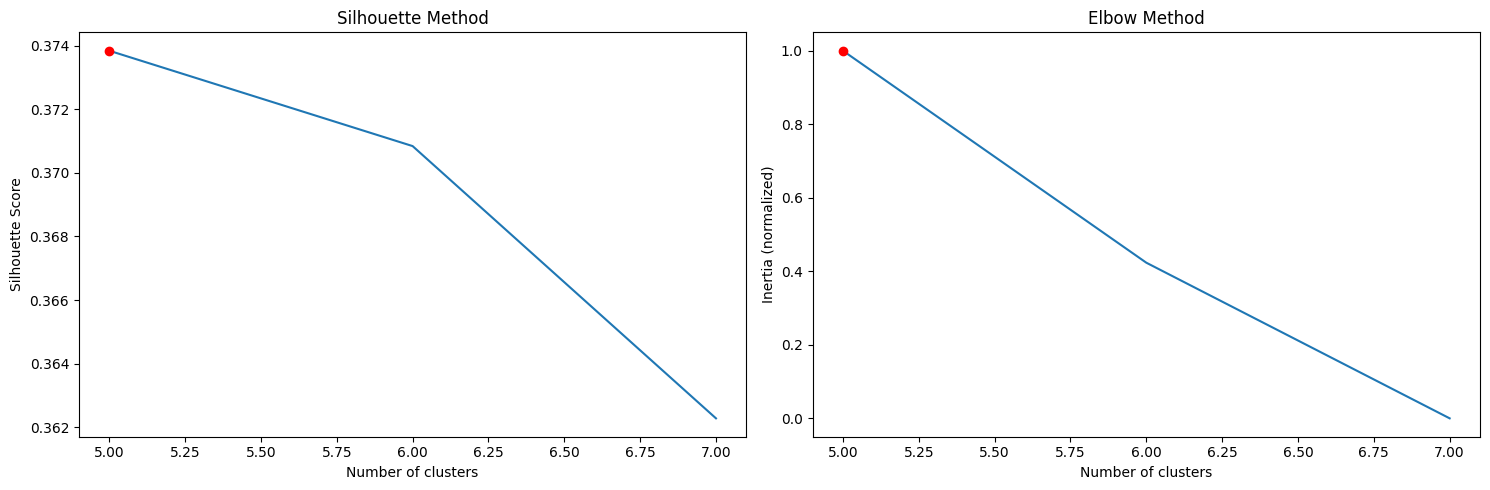

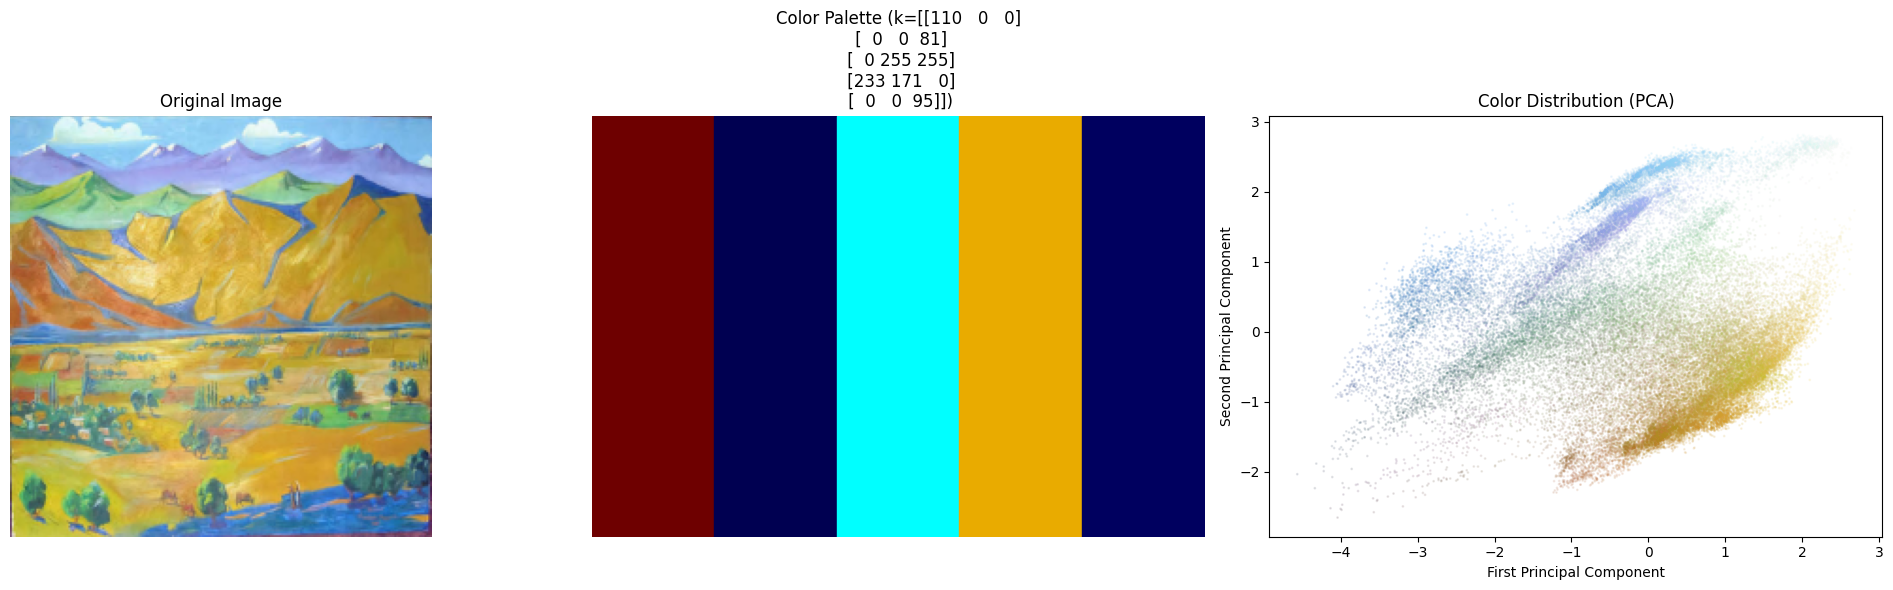

In [48]:
pipeline.fit_transform(images_random_test.values[2])

Usando el modelo de Aglomerativo:

In [50]:
pipeline_aglo = Pipeline([('ReadImages', ReadImages()), 
                     ('ImagePreprocessor', ImagePreprocessor()),
                     ('ModelEvaluation', ModelEvaluation()) # Por defecto es 'aglo'
                     ])

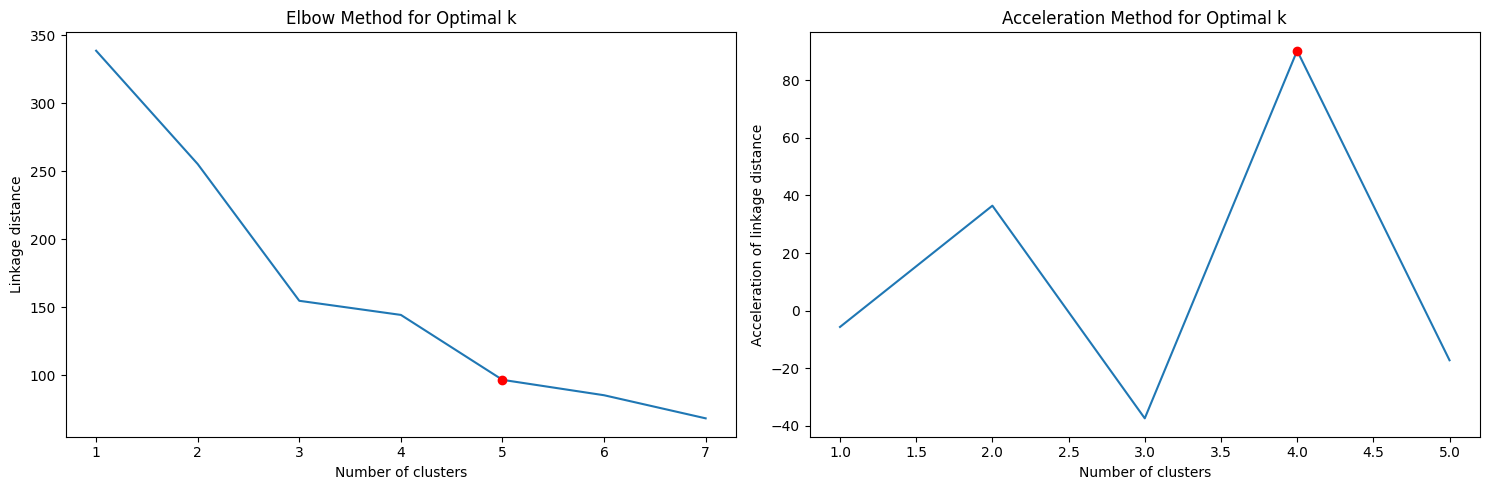

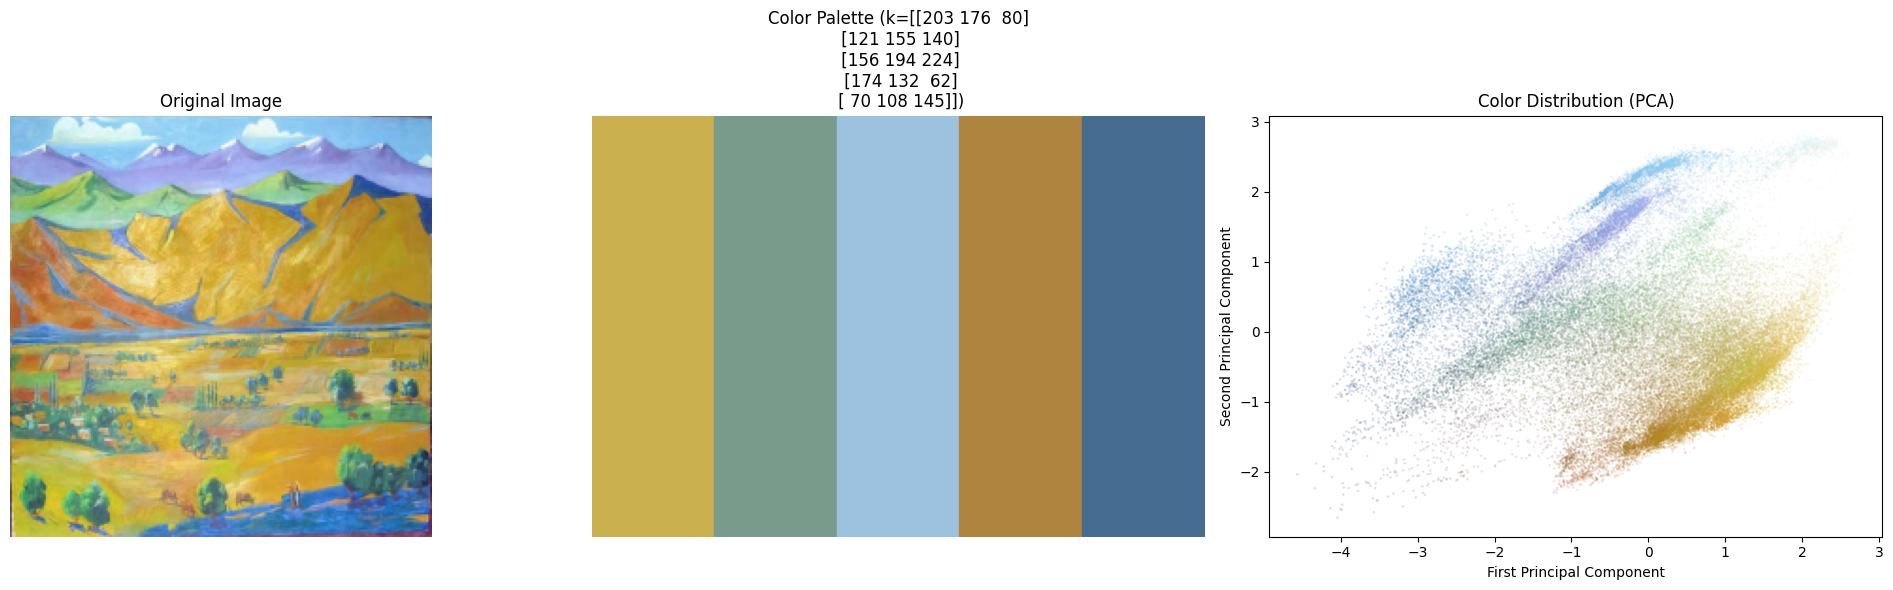

In [53]:
pipeline_aglo.fit_transform(images_random_test.values[2])

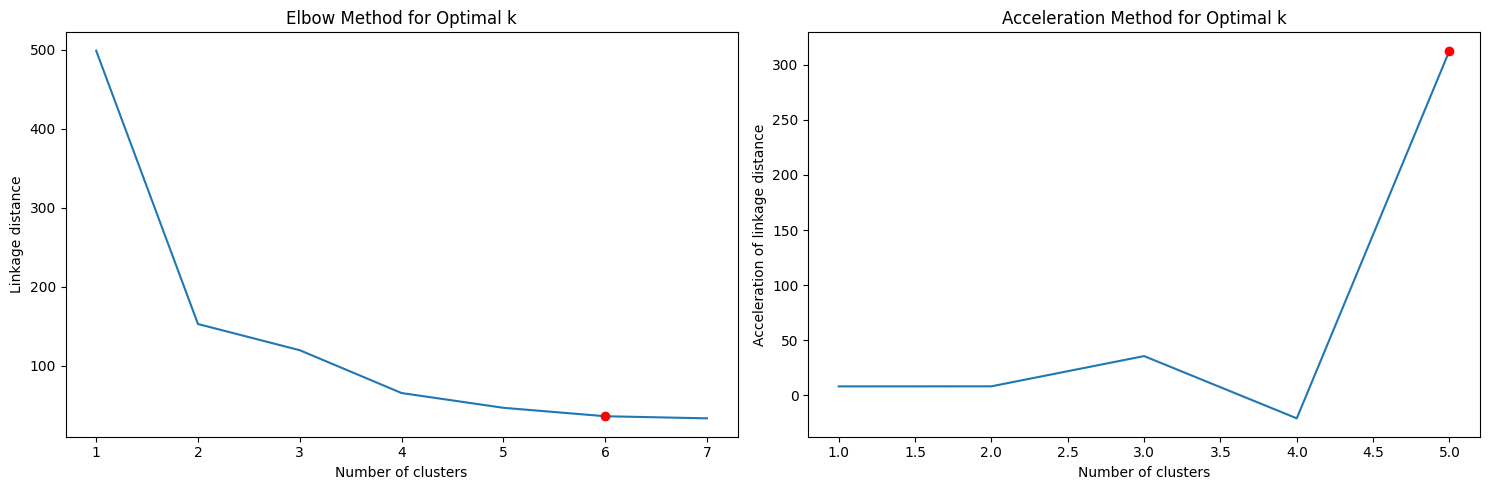

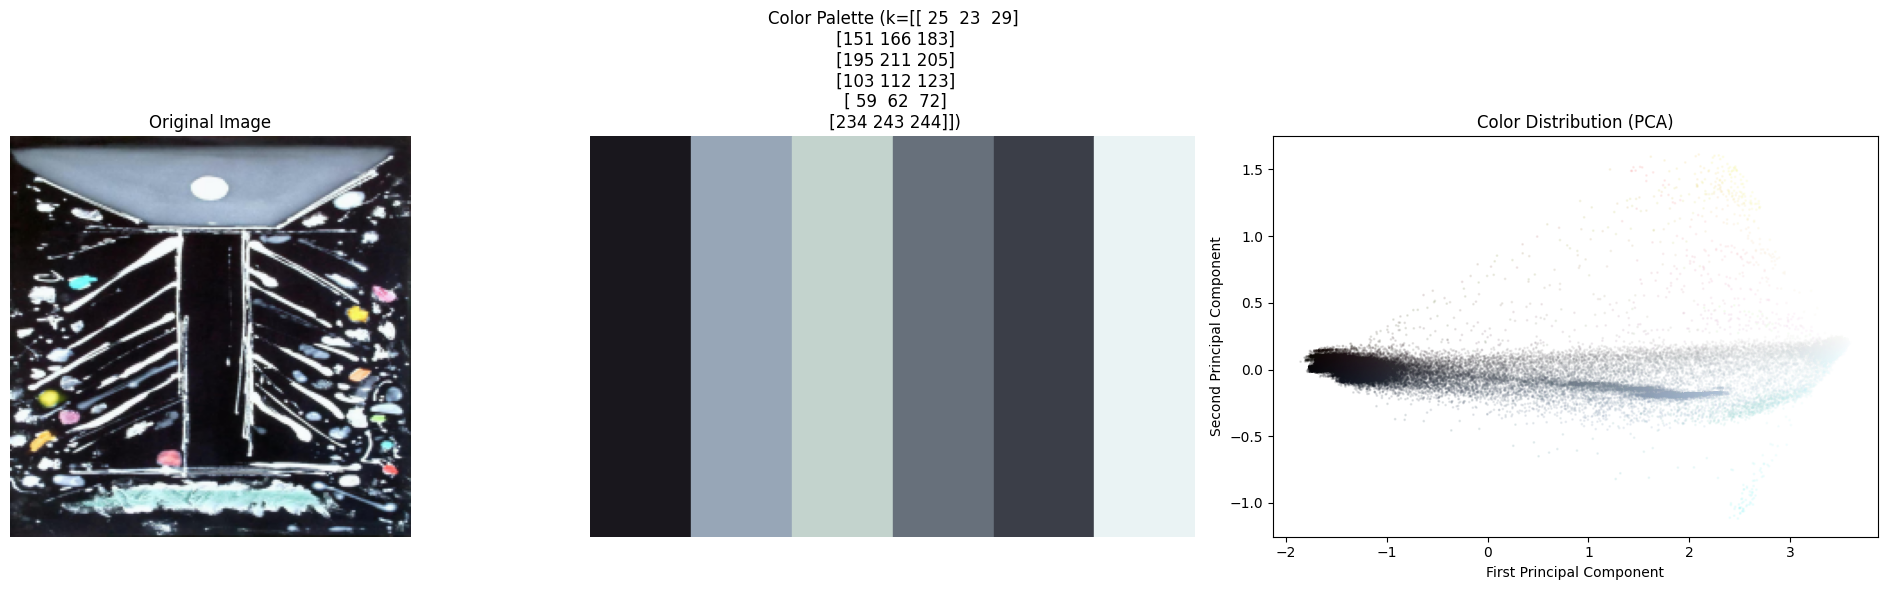

In [52]:
pipeline_aglo.fit_transform(images_random_test.values[0])

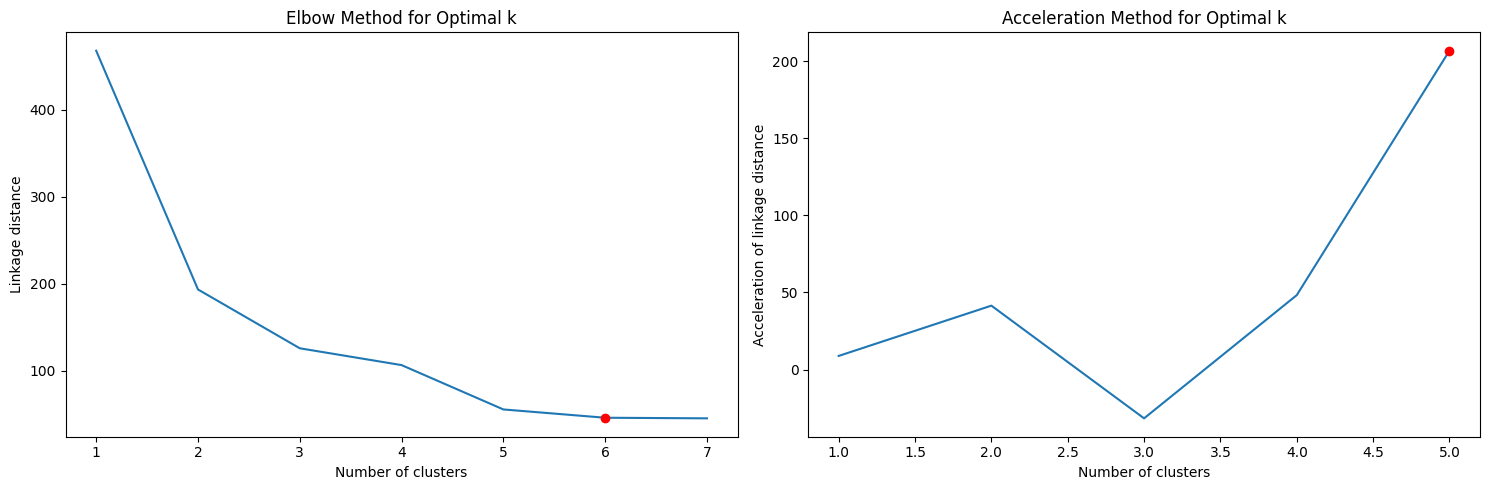

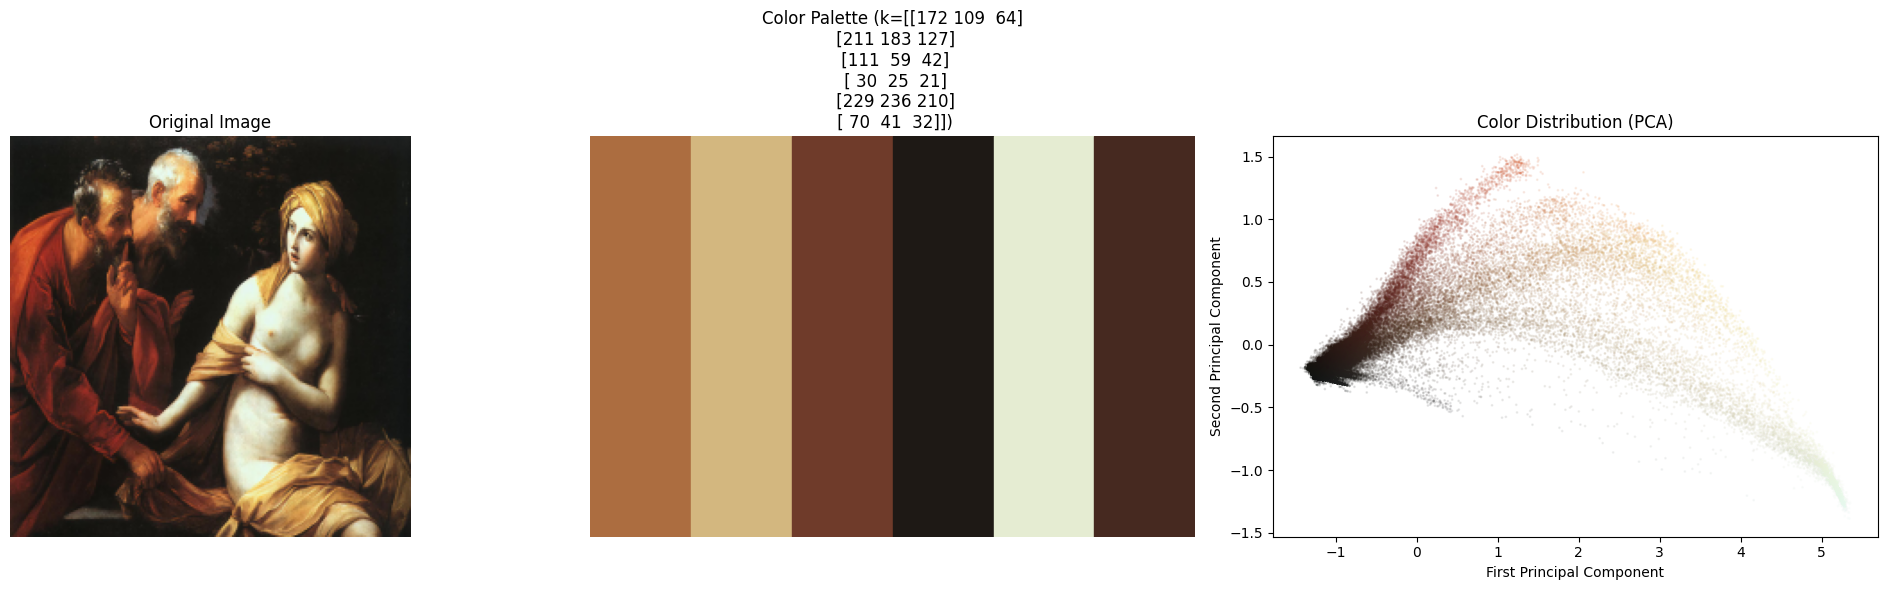

In [54]:
pipeline_aglo.fit_transform(images_random_test.values[1])

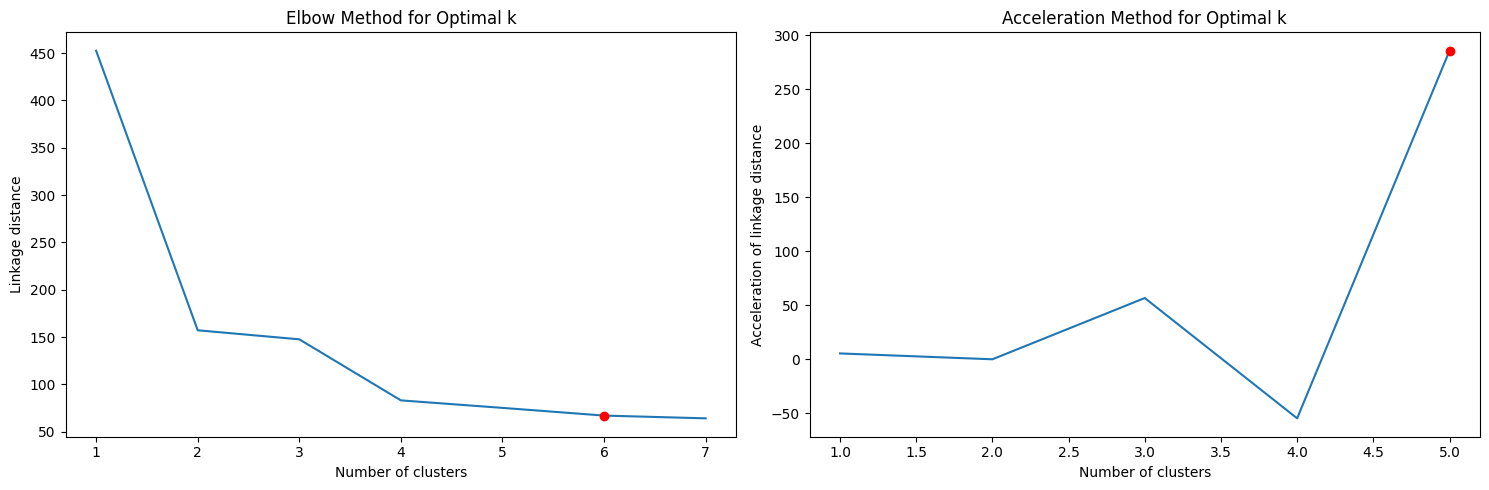

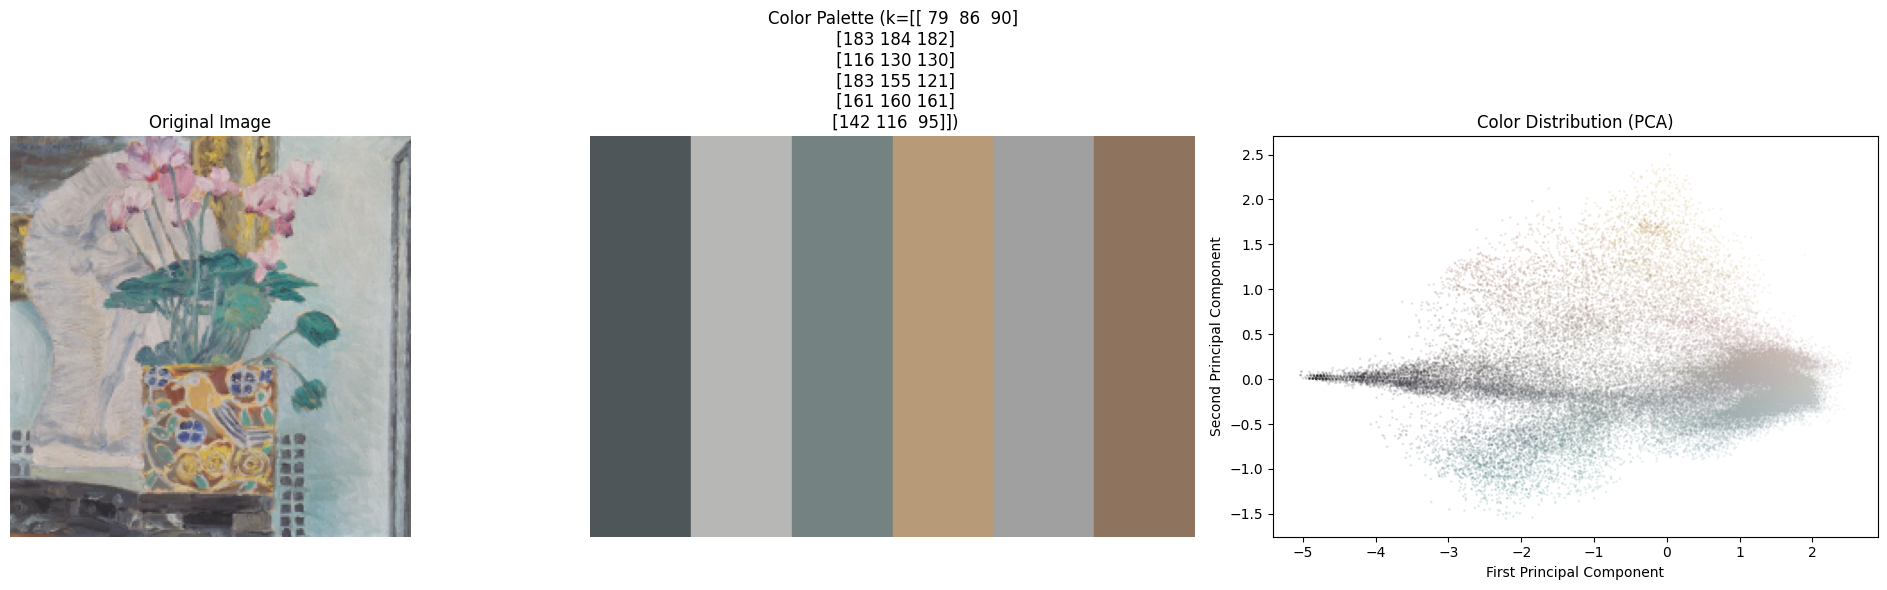

In [55]:
pipeline_aglo.fit_transform(images_random_test.values[3])


### Conclusiones

- En general, el modelo K-means es más rápido y eficiente que el modelo aglomerativo, ya que converge a una solución en menos tiempo.
- El modelo aglomerativo es más robusto y preciso que el de K-means. Se observa que el modelo K-means no es capaz de capturar la totalidad de los colores en la imagen, mientras que el modelo aglomerativo logra una mejor representación de los colores y una distribución más adecuada de los clusters.
- En las métricas de evaluación, se obtiene un número menor de clusters con K-means en comparación con el modelo aglomerativo, lo que puede influir en la calidad de los resultados.
- Los centroides de los clusters generados por K-means no siempre representan los colores de la imagen de manera precisa, lo que puede llevar a una paleta de colores menos fiel a la imagen original.